In [4]:
import torch
import torch.nn as nn
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
from torchinfo import summary
from torch.utils.data import Dataset, dataloader
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [5]:
print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
input_window = 7 # 7 days in week
output_window = 1 # predict for the next day
BATCH_SIZE = 100
print(device)

2.2.2+cu121
cuda


In [6]:
def create_inout_sequences(input_data, input_window):
    inout_seq = []
    L = len(input_data)
    for i in range(L - input_window):
        train_seq = input_data[i:i + input_window]
        train_label = input_data[i + output_window: i + input_window + output_window]
        inout_seq.append((train_seq, train_label))
    return torch.FloatTensor(inout_seq)

In [7]:
def get_data(data_raw, split):
    split = round(split * len(data_raw))
    train_data = data_raw[:split]
    test_data = data_raw[split:]

    train_data = train_data.cumsum()
    train_data = 2 * train_data  # Training data scaling

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data, input_window)
    train_sequence = train_sequence[:-output_window]

    test_sequence = create_inout_sequences(test_data, input_window)
    test_sequence = test_sequence[:-output_window]

    return train_sequence.to(device), test_sequence.to(device)

In [8]:
# create batches from input and target sequence 
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    data_in = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return data_in, target

In [9]:
composite_df = pd.read_csv("composite_stocks.csv")
DJI_close = composite_df['DJI']

In [10]:
DJI_log_prices = np.diff(np.log(DJI_close))
DJI_log_prices_cumsum = DJI_log_prices.cumsum()
DJI_close

0      33136.371094
1      33269.769531
2      32930.078125
3      33630.609375
4      33517.648438
           ...     
245    37385.968750
246    37545.328125
247    37656.519531
248    37710.101562
249    37689.539062
Name: DJI, Length: 250, dtype: float64

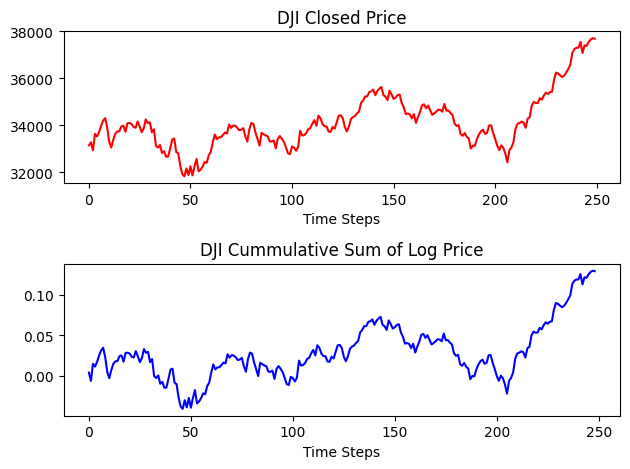

In [11]:
fig1, ax1 = plt.subplots(2, 1)
ax1[0].plot(DJI_close, color='red')
ax1[0].set_title('DJI Closed Price')
ax1[0].set_xlabel('Time Steps')

ax1[1].plot(DJI_log_prices_cumsum, color='blue')
ax1[1].set_title('DJI Cummulative Sum of Log Price')
ax1[1].set_xlabel('Time Steps')

fig1.tight_layout()

In [12]:
train_data, test_data = get_data(DJI_log_prices, 0.7) # 70-30 split

C:\Users\andyz\AppData\Local\Temp\ipykernel_23868\1471902572.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.FloatTensor(inout_seq)


In [13]:
from Transformer import Transformer
model = Transformer().to(device)
criterion = nn.MSELoss()
EPOCHS = 150
learning_rate = 0.00005
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

c:\Users\andyz\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [14]:
def train(train_data):
  # model train
  model.train()

  total_loss = 0
  start_time = time.time()

  for batch, i in enumerate(range(0, len(train_data)-1, BATCH_SIZE)):
    data, targets = get_batch(train_data, i, BATCH_SIZE)
    # apply gradient descent
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, targets)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 0.7)
    optimizer.step()

    total_loss = total_loss + loss.item()
    # log_interval = int(len(train_data) / BATCH_SIZE / 5)
    log_interval = max(int(len(train_data) / BATCH_SIZE / 5), 1)
    if batch % log_interval == 0 and batch > 0:
        cur_loss = total_loss / log_interval
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5d}/{:5d} batches | '
              'lr {:02.10f} | {:5.2f} ms | '
              'loss {:5.7f}'.format(
                epoch, batch, len(train_data) // BATCH_SIZE, scheduler.get_lr()[0],
                elapsed * 1000 / log_interval,
                cur_loss))
        total_loss = 0
        start_time = time.time()


In [15]:
def evaluate(model, data_source):
    model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = model(data)
            total_loss = total_loss + len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

In [16]:
def predict(model, sequences):
    start_timer = time.time()
    model.eval()
    predicted_seq = torch.Tensor(0)
    real_seq = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)
            predicted_seq = torch.cat((predicted_seq, output[-1].view(-1).cpu()), 0)
            real_seq = torch.cat((real_seq, target[-1].view(-1).cpu()), 0)
    timed = time.time() - start_timer
    print(f"{timed} sec")

    return predicted_seq, real_seq

In [61]:
for epoch in range(1, EPOCHS+1):
  epoch_start_time = time.time()
  train(train_data)

  if epoch % EPOCHS == 0:
    val_loss = evaluate(model, test_data)
    print('-' * 80)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch,
                                                                                (time.time() - epoch_start_time),
                                                                                val_loss))
    print('-' * 80)

  else:
    print('-' * 80)
    print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
    print('-' * 80)

  scheduler.step()

c:\Users\andyz\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:402: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |     1/    1 batches | lr 0.0000500000 | 92.61 ms | loss 0.5154388
--------------------------------------------------------------------------------
| end of epoch   1 | time:  0.13s
--------------------------------------------------------------------------------
| epoch   2 |     1/    1 batches | lr 0.0000451250 | 89.41 ms | loss 0.4015141
--------------------------------------------------------------------------------
| end of epoch   2 | time:  0.09s
--------------------------------------------------------------------------------
| epoch   3 |     1/    1 batches | lr 0.0000428687 | 74.12 ms | loss 0.2878199
--------------------------------------------------------------------------------
| end of epoch   3 | time:  0.07s
--------------------------------------------------------------------------------
| epoch   4 |     1/    1 batches | lr 0.0000407253 | 23.56 ms | loss 0.2283359
--------------------------------------------------------------------------------
| end of ep

In [17]:
predicted_seq, real_seq = predict(model, test_data)

c:\Users\andyz\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


0.32219719886779785 sec


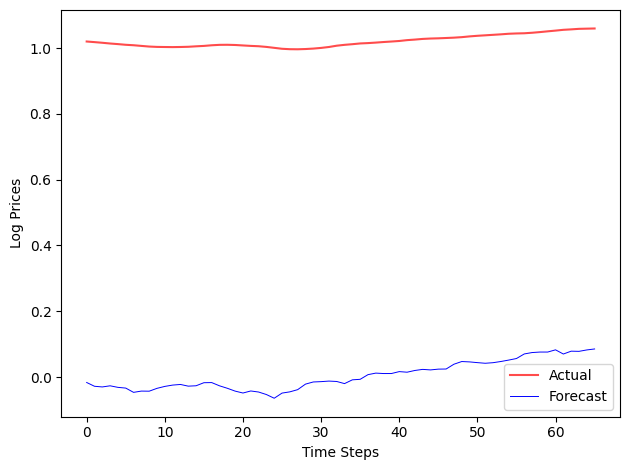

In [18]:
fig2, ax2 = plt.subplots(1, 1)

ax2.plot(predicted_seq, color='red', alpha=0.7)
ax2.plot(real_seq, color='blue', linewidth=0.7)
ax2.legend(['Actual', 'Forecast'])
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Log Prices')

fig2.tight_layout()